In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
import torchvision.utils as vutils
import itertools

import os
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

# Model

In [2]:
nc = 1
ndf = 64
ngf = 64

class MyModel(nn.Module):
    def __init__(self,latent_dim,nClusters):
        super(MyModel,self).__init__()
        
        self.latent_dim = latent_dim
        self.nClusters = nClusters
        self.pi_=nn.Parameter(torch.FloatTensor(self.nClusters,).fill_(1)/self.nClusters,requires_grad=True)
        self.mu_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        self.log_var_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    #def reparameterize(self, mu, logvar):
        #std = torch.nan_to_num(logvar.mul(0.5).exp_(),nan=0)  ## Reparameterize nan??
        #std = logvar.mul(0.5).exp_()
        #eps = Variable(std.data.new(std.size()).normal_())
          # num = np.array([[ 1.096506  ,  0.3686553 , -0.43172026,  1.27677995,  1.26733758,
          #       1.30626082,  0.14179629,  0.58619505, -0.76423112,  2.67965817]], dtype=np.float32)
          # num = np.repeat(num, mu.size()[0], axis=0)
          # eps = Variable(torch.from_numpy(num))
        #return eps.mul(std).add_(mu)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def gaussian_pdf_log(self,x,mu,log_sigma2):
        return -0.5*(torch.sum(np.log(np.pi*2)+log_sigma2+(x-mu).pow(2)/torch.exp(log_sigma2),1))
    
    def gaussian_pdfs_log(self,x,mus,log_sigma2s):
    #def gaussian_pdfs_log(x,mus,log_sigma2s):
        G=[]
        for c in range(self.nClusters):
            G.append(self.gaussian_pdf_log(x,mus[c:c+1,:],log_sigma2s[c:c+1,:]).view(-1,1))
        return torch.cat(G,1)
    
    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        #decoded = self.decode(mu)
        z = self.reparameterize(mu,logvar)
        z = torch.nan_to_num(z,nan=0)
        #z = torch.randn_like(mu)*torch.exp(logvar/2)+mu
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar
    
    def predict(self,x):
        z_mu, z_sigma2_log = self.encode(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        z = torch.nan_to_num(z,nan=0)
        pi = self.pi_
        log_sigma2_c = self.log_var_c
        mu_c = self.mu_c
        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_sigma2_c))

        yita=yita_c.detach().cpu().numpy()
        #print(yita)
        return np.argmax(yita,axis=1)
        
    def RE(self,recon_x,x):
        return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),reduction='sum')
        #return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),size_average=False)

    def KLD(self,mu,log_var):
        det=1e-10

        pi=self.pi_
        log_var_c = self.log_var_c
        mu_c = self.mu_c

        z = torch.randn_like(mu) * torch.exp(log_var/2) + mu
        z = torch.nan_to_num(z,nan=0)

        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_var_c))+det
        yita_c = yita_c/(yita_c.sum(1).view(-1,1))
        loss = 0.5*torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+
                                                    torch.exp(log_var.unsqueeze(1)-log_var_c.unsqueeze(0))+
                                                    (mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))
        loss -= torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+log_var,1))
        return loss
        #return torch.nan_to_num(loss,nan=0)

    def loss_function(self,recon_x,x,mu,log_var):
        return self.RE(recon_x,x)+self.KLD(mu,log_var)

# Input Parameter

In [3]:
latent_dim = 10
nClusters = 13
batch = 100

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available else {}

# DataLoader

In [5]:
import h5py

In [6]:
data_list = ['../data/normal_dataset.h5','../data/Anomaly_dataset.h5']

In [7]:
imageList=[]
labelList=[]
for file_path in data_list:
    print('Loading data from ', file_path)
    dataset = h5py.File(file_path,'r',libver='latest',swmr=True)
    FimageList=[]
    FlabelList=[]
    for gName,group in dataset.items():
        for dName,data in group.items():
            if dName == 'images':
                FimageList.append(data)
            elif dName == 'labels':
                FlabelList.append(data)

    if len(FimageList) >= 2:
        #print("More than 2 gropus in File")
        image_concat = []
        for i in range(0,len(FimageList)):
            image_concat.append(FimageList[i][:])
        imageList.append(np.concatenate(image_concat))
        label_concat = []
        for i in range(0,len(FlabelList)):
            label_concat.append(FlabelList[i][:])
        labelList.append(np.concatenate(label_concat))
    else:
        imageList.append(FimageList[0][:])
        labelList.append(FlabelList[0][:])
imageList = np.concatenate(imageList)
labelList = np.concatenate(labelList)
print('input image shape : ',imageList.shape)
print('input label shape : ',labelList.shape)
ds = TensorDataset(torch.tensor(imageList),torch.tensor(labelList))
length = [int(len(ds)*0.7),int(len(ds)*0.2)]
length.append(len(ds)-sum(length))

trnSet,valSet,tstSet=torch.utils.data.random_split(ds,length)

#train Loader
train_loader = DataLoader(trnSet, batch_size=batch, shuffle=True, **kwargs)
#test Loader
test_loader = DataLoader(valSet, batch_size=batch, shuffle=False, **kwargs)

Loading data from  ../data/normal_dataset.h5
Loading data from  ../data/Anomaly_dataset.h5
input image shape :  (72100, 1, 28, 28)
input label shape :  (72100,)


# Initial $\gamma$-training

In [8]:
# Initial gamma-training parameter
gamma = 1e-5
gamma_step = 500

In [9]:
def gamma_training(gamma,steps,dataloader):
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    print('Starting initial gamma training for ',steps,'steps.')
    for batch_idx, (data,_) in tqdm(enumerate(train_loader)):

        #print(batch_idx+1,'step trained')
        data = Variable(data)
        data = data.cuda()
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = model.RE(recon_batch,data) + gamma * model.KLD(mu,logvar)
        loss.backward()
        #print(loss.item())
        optimizer.step()
        
        if batch_idx +1 == steps:
            print('Training completed')
            break

In [10]:
net = MyModel(latent_dim=latent_dim,nClusters=nClusters)

In [11]:
model = net.cuda()

In [12]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
                      0.0769, 0.0769, 0.0769, 0.0769], device='cuda:0')),
             ('mu_c',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                     

In [13]:
gamma_training(gamma=gamma,steps=gamma_step,dataloader=train_loader)

Starting initial gamma training for  500 steps.


499it [00:13, 36.08it/s]


Training completed


In [14]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993, 0.3993,
                      0.3993, 0.3993, 0.3993, 0.3993], device='cuda:0')),
             ('mu_c',
              tensor([[ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
                        0.3542, -0.4761],
                      [ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
                        0.3542, -0.4761],
                      [ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
                        0.3542, -0.4761],
                      [ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
                        0.3542, -0.4761],
                      [ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
                        0.3542, -0.4761],
                      [ 0.4498, -0.3789,  0.4346,  0.4800, -0.2483, -0.4667, -0.4985,  0.4755,
         

# mini-Batch GMM initialization

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
k=round(len(train_loader)*0.5)

In [16]:
subset = np.random.randint(len(train_loader),size=k*batch)

In [17]:
train_subset_loader = DataLoader(torch.utils.data.Subset(trnSet,subset))

In [18]:
Z=[]
Y=[]
print('GMM Initializing with ',k*batch, 'MC samples')
with torch.no_grad():
    for batch_idx, (data,y) in tqdm(enumerate(train_subset_loader)):
        data = data.cuda()
        
        mu,logvar = model.encode(data)
        
        #assert nn.functional.mse_loss(mu,logvar)==0
        Z.append(mu)
        Y.append(y)
    Z=torch.cat(Z,0).detach().cpu().numpy()
    Y=torch.cat(Y,0).detach().cpu().numpy()
    
    kmeans = KMeans(n_clusters=nClusters, random_state=0)
    kmeans.fit(Z)
    
    #model.mu_c.data = torch.from_numpy(kmeans.cluster_centers).cuda().float()
    
    gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04),means_init = kmeans.cluster_centers_,random_state=100)
    #gmm = GaussianMixture(n_components=nClusters,covariance_type='diag',max_iter=int(1e+04))
    
    pre = gmm.fit_predict(Z)
    
    model.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
    model.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
    model.log_var_c.data = torch.log(torch.from_numpy(gmm.covariances_).cuda().float())

GMM Initializing with  25200 MC samples


25200it [00:27, 923.26it/s]


In [19]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0335, 0.1189, 0.0683, 0.0684, 0.0461, 0.0684, 0.1034, 0.1110, 0.0760,
                      0.0726, 0.0731, 0.0805, 0.0799], device='cuda:0')),
             ('mu_c',
              tensor([[ 2.1977e+00,  1.5441e+00,  4.5797e+00,  7.0913e+00,  2.7189e+00,
                       -6.4722e+00, -9.2989e+00,  4.7186e+00,  1.0580e-02, -8.4268e+00],
                      [ 1.9430e+00, -8.7929e+00,  6.3055e+00,  6.4782e+00, -1.9935e+00,
                       -8.0837e+00, -4.6551e+00,  7.4559e+00,  2.8567e+00, -9.7684e+00],
                      [ 2.1701e+00, -4.2347e+00,  5.2779e+00,  6.7020e+00,  2.9655e-01,
                       -7.3624e+00, -6.4401e+00,  6.1399e+00,  1.5098e+00, -9.3773e+00],
                      [ 2.0598e+00,  1.1098e-01,  4.6076e-01,  3.5915e+00,  2.6872e+00,
                       -3.4382e+00, -2.4619e+00,  1.9054e+00, -6.7975e-01, -5.8307e+00],
                      [ 1.6836e+00, -1.3608e+01,  7.9877e+00,  6.8966e+00, -4.595

# Periodic $\beta$ - Annealing

In [20]:
n_iter = len(train_loader)
n_cycle = 5
ratio = 0.5
start = gamma
stop = gamma + 1

L = np.ones(n_iter)
period = n_iter/n_cycle
step = (stop-start)/(period*ratio)

for c in range(n_cycle):
    v, i = start, 0
    while v<= stop and (int(i+c*period)<n_iter):
        L[int(i+c*period)]=v
        v += step
        i += 1

# Inverse Min-Max Transform : Avoid NaN Losses

# Test Training

In [21]:
epochs = 300
batch_size = 100 
optimizer=optim.Adam(model.parameters())
outf = './test'

In [22]:
def train(epoch):
    model.train()
    #print('train')
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        #print(data.shape)
        #print(data)
        if torch.cuda.is_available():
            data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        
        beta = L[batch_idx]
        
        #print(recon_batch.shape,mu.shape,logvar.shape)
        #print(recon_batch.view(-1,784))
        #print(recon_batch.shape)
        #print(recon_batch)
        #print(data.shape)
        #print(model.RE(recon_batch,data))
        #print(model.KLD(mu,logvar))
        loss = model.RE(recon_batch,data) + beta * model.KLD(mu,logvar)
        
        #loss = model.loss_function(recon_batch,data,mu,logvar)
        
        if torch.isnan(loss.data.cpu()):
        #if np.isnan(loss.data.item()):
            print('NaN Loss!')
            print('RE : ',model.RE(recon_batch,data)/len(recon_batch))
            print('KL-D : ',model.KLD(mu,logvar))
            break
            
        else:
            loss.backward()
            #print(loss.data.item())
            train_loss += loss.data
            #print(loss.data)
            optimizer.step()
                
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.data / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    #if epoch % 5 == 0:
        #torch.save(model.state_dict(),'./model_%d.pth' % (epoch))
    #return (train_loss/len(train_loader.dataset)).cpu()
    return train_loss/len(train_loader.dataset)

In [23]:
def test(epoch):
    model.eval()
    #print('validation')
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).data
        if i == 0:
            n = min(data.size(0), 16)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss.cpu()
    #return test_loss

In [24]:
best_=100
best_epoch=0
train_loss_arr=[]
test_loss_arr=[]
for epoch in range(1,epochs+1):
    train_loss_arr.append(train(epoch).cpu().numpy())
    val_loss = test(epoch)
    test_loss_arr.append(val_loss.cpu().numpy())
    if val_loss.cpu() < best_:
    #if val_loss < best_:
        best_=val_loss.cpu()
        #best_ = val_loss
        best_epoch = epoch
        print('Save model at epoch ',best_epoch,' Validation Loss : ',best_.item())
        torch.save(model.state_dict(),'./s3vdc_test5.pth')
    
    if torch.isnan(val_loss.cpu()): 
        break
print("Model is saved at epoch ",best_epoch," | Validation Loss : ",best_.item(),"Saved path : ./s3vdc5.pth")

Train Epoch: 1 [0/50470 (0%)]	Loss: 177.066086
Train Epoch: 1 [10000/50470 (20%)]	Loss: 165.718414
Train Epoch: 1 [20000/50470 (40%)]	Loss: 139.426285
Train Epoch: 1 [30000/50470 (59%)]	Loss: 125.305473
Train Epoch: 1 [40000/50470 (79%)]	Loss: 112.287575
Train Epoch: 1 [50000/50470 (99%)]	Loss: 107.911697
====> Epoch: 1 Average loss: 142.6439


C:\Users\jysin\AppData\Local\Temp/ipykernel_14308/3391578916.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


====> Test set loss: 109.4420
Train Epoch: 2 [0/50470 (0%)]	Loss: 108.640701
Train Epoch: 2 [10000/50470 (20%)]	Loss: 103.898903
Train Epoch: 2 [20000/50470 (40%)]	Loss: 103.470642
Train Epoch: 2 [30000/50470 (59%)]	Loss: 89.982460
Train Epoch: 2 [40000/50470 (79%)]	Loss: 97.192345
Train Epoch: 2 [50000/50470 (99%)]	Loss: 94.584526
====> Epoch: 2 Average loss: 96.9093
====> Test set loss: 95.2155
Save model at epoch  2  Validation Loss :  95.21552276611328
Train Epoch: 3 [0/50470 (0%)]	Loss: 94.703178
Train Epoch: 3 [10000/50470 (20%)]	Loss: 88.849655
Train Epoch: 3 [20000/50470 (40%)]	Loss: 85.576256
Train Epoch: 3 [30000/50470 (59%)]	Loss: 83.567284
Train Epoch: 3 [40000/50470 (79%)]	Loss: 83.037598
Train Epoch: 3 [50000/50470 (99%)]	Loss: 83.963181
====> Epoch: 3 Average loss: 86.8015
====> Test set loss: 83.6537
Save model at epoch  3  Validation Loss :  83.65372467041016
Train Epoch: 4 [0/50470 (0%)]	Loss: 80.335495
Train Epoch: 4 [10000/50470 (20%)]	Loss: 84.766876
Train Epoch: 4

====> Test set loss: 72.6640
Train Epoch: 22 [0/50470 (0%)]	Loss: 69.744453
Train Epoch: 22 [10000/50470 (20%)]	Loss: 71.032974
Train Epoch: 22 [20000/50470 (40%)]	Loss: 70.320465
Train Epoch: 22 [30000/50470 (59%)]	Loss: 69.332115
Train Epoch: 22 [40000/50470 (79%)]	Loss: 70.911484
Train Epoch: 22 [50000/50470 (99%)]	Loss: 70.970024
====> Epoch: 22 Average loss: 69.0466
====> Test set loss: 72.4494
Save model at epoch  22  Validation Loss :  72.44944763183594
Train Epoch: 23 [0/50470 (0%)]	Loss: 68.755348
Train Epoch: 23 [10000/50470 (20%)]	Loss: 68.022598
Train Epoch: 23 [20000/50470 (40%)]	Loss: 66.476616
Train Epoch: 23 [30000/50470 (59%)]	Loss: 73.143066
Train Epoch: 23 [40000/50470 (79%)]	Loss: 71.058777
Train Epoch: 23 [50000/50470 (99%)]	Loss: 66.967041
====> Epoch: 23 Average loss: 68.7130
====> Test set loss: 72.4336
Save model at epoch  23  Validation Loss :  72.43357849121094
Train Epoch: 24 [0/50470 (0%)]	Loss: 67.562393
Train Epoch: 24 [10000/50470 (20%)]	Loss: 69.986504


In [25]:
model.state_dict()

OrderedDict([('pi_',
              tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                     device='cuda:0')),
             ('mu_c',
              tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                      [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
               

In [26]:
model.load_state_dict(torch.load('./s3vdc_test5.pth'))

<All keys matched successfully>

In [27]:
model.state_dict()

OrderedDict([('pi_',
              tensor([12.2066, 13.5060, 13.2952, 11.6685, 13.1312, 12.2157, 13.1161, 12.3118,
                      12.6660, 13.4136, 13.4246, 13.5196, 13.2087], device='cuda:0')),
             ('mu_c',
              tensor([[  3.9703,  -3.2803,   3.2789,   7.8369,   2.5782,  -8.9761,  -8.2301,
                         6.5605,   1.4335, -12.7420],
                      [  3.9516,  -4.2051,   3.4335,   7.8250,   2.4464,  -9.0027,  -8.0537,
                         6.0677,   1.4338, -12.8434],
                      [  4.0003,  -3.2682,   3.2963,   7.7637,   2.5723,  -8.5805,  -7.9556,
                         6.2740,   1.4066, -12.3292],
                      [  3.9103,  -3.3509,   3.1155,   7.8269,   2.5503,  -8.2979,  -7.6147,
                         6.2432,   1.4256, -12.3074],
                      [  3.9174,  -5.8725,   3.6752,   7.6513,   2.0393,  -9.0525,  -8.0424,
                         6.5793,   1.4893, -12.4819],
                      [  3.9282,  -3.0140

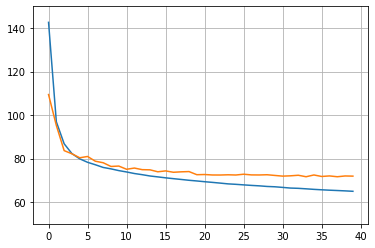

In [46]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr)
plt.plot(test_loss_arr)
plt.ylim(50,150)
plt.grid()
plt.show()

In [29]:
t_im,t_la = next(iter(test_loader))
t_imc = t_im.cuda()
t_re,t_mu_,t_logvar = model(t_imc)
t_mu2,t_logvar2 = model.encode(t_im.cuda())
t_z = model.reparameterize(t_mu2,t_logvar2)
t_re2 = model.decode(t_z)

In [30]:
len(t_re)

100

In [31]:
#(model.RE(t_re,t_imc)/len(t_re))+model.KLD(t_mu_,t_logvar)
model.RE(t_re,t_imc)/len(t_re)
#model.KLD(t_mu_,t_logvar)

tensor(68.4959, device='cuda:0', grad_fn=<DivBackward0>)

In [47]:
model.KLD(t_mu_,t_logvar)

tensor(42.7265, device='cuda:0', grad_fn=<SubBackward0>)

In [32]:
t_la[0]

tensor(3., dtype=torch.float64)

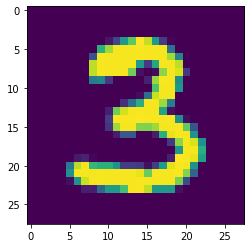

In [33]:
plt.imshow(t_im[0][0][:])

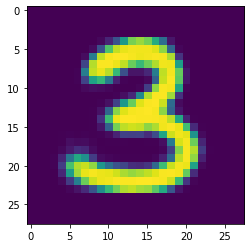

In [34]:
plt.imshow(t_re[0][0][:].detach().cpu().numpy())

# Prediction Test

In [35]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [36]:
x_1[0][0].shape

torch.Size([1, 28, 28])

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


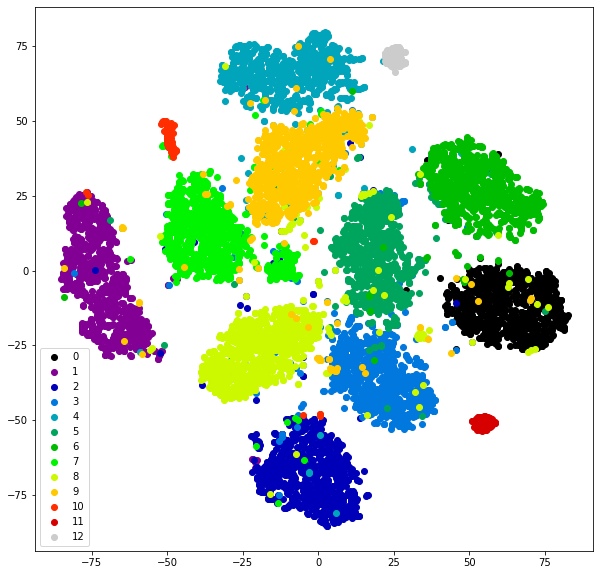

In [37]:
from sklearn.manifold import TSNE
x_t = torch.cat(x_1[:100])
y_t = torch.cat(y_1[:100])
recon,mu,logvar = model(x_t.cuda())
z = model.reparameterize(mu,logvar).detach().cpu().numpy()

tsne = TSNE(n_components=2)
tsneArr = tsne.fit_transform(z)

c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(y_t)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(y_t))):
    plt.scatter(tsneArr[y_t==i,0],tsneArr[y_t==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')

In [38]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [39]:
x_2 = torch.cat(x_1[:])
y_2 = torch.cat(y_1[:])

In [40]:
model_prediction = model.predict(x_2[:5000].cuda())

In [41]:
gt = y_2[:5000]

In [42]:
for i in range(0,nClusters):
    print('model prediction for ', i, ' : ',model_prediction[gt==i].reshape(1,len(model_prediction[gt==i])).flatten())

model prediction for  0  :  [10 10 10 11 11 10  4 10  9 10 10 10 10 11  4 10 10  4  4 10  9  9 10  4
 10  4  4  4 10 10  4 10  4  4  4 10  4  9 11  4 10 10  4  4 10  4 10 10
  4  9 10  4  4 10  4  4 11 11 10  4  4 10 10 10 10  4 10 10 10  4  4  4
  9  4 10  4 10  4 10 10 10 10  9 10 11 10  4 10  9 11 10 10 10 10  9  4
 10 10 10 11  4 11 10  4 10 10 11  9 10  9  4  4  4 10 10 10 10 10 10  4
 10  4  4  9 10  4  9 10  9 10  4 10 10 10 10  4 10 10  8 10 10  4  4  4
  4  4 10  4 11 10 10  4 10 10  4  4  9  4 10  9  4  4  4  4 10 10 10  9
  4 10  4  4 10 10 10 10  4 10  4  4  4  4 10  9 11  4 10  4  4  4  4  4
  4 10 10 10 10 10  4 10  4  4  4 10 10 10 10 10 10  9  4 10 10  4  4 10
  9 11 10  4  9 10  4 10  9 10 11 10 10  4 10 10  4 10  4 10  4 10 10 10
 10 10 10 10  4 10 10 11  9 10  9 11 11 10 10 10 10 11  4 11 10  4 11  4
 10 10  4 11 11  9  4 10 10  4 11 10  4 10  4 10 10 10 10  4 10 10 10  9
 11  4 10  4  4 10 10  9 10  4 10 11  4 10 10  4 11 10  9  4  4 11 10  4
 10 10  4  4 11  4 10 1

In [43]:
for i in range(0,nClusters):
    uni,count = np.unique(model_prediction[gt==i].reshape(1,len(model_prediction[gt==i])).flatten(),return_counts=True)
    print('GT : ',i,'Model prediction :',uni[np.argmax(count)])

GT :  0 Model prediction : 10
GT :  1 Model prediction : 10
GT :  2 Model prediction : 10
GT :  3 Model prediction : 10
GT :  4 Model prediction : 10
GT :  5 Model prediction : 4
GT :  6 Model prediction : 10
GT :  7 Model prediction : 10
GT :  8 Model prediction : 10
GT :  9 Model prediction : 10
GT :  10 Model prediction : 4
GT :  11 Model prediction : 4
GT :  12 Model prediction : 9


In [44]:
for i in range(0,nClusters):
    uni,count = np.unique(gt[model_prediction.reshape(1,len(np.array(model_prediction)))==i].flatten(),return_counts=True)
    print(uni, count)
    #print('Most frequent GT in model cluster ',i,' is ',uni[np.argmax(count)])

[] []
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [ 3 22 39 24 98  7 16 26 38  5  2  3]
[ 2.  3.  4.  5.  6.  7.  8.  9. 11. 12.] [4 1 7 7 2 4 4 3 6 3]
[] []
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [157   2 147 111  95 194  98  43  99  47  14  39  12]
[] []
[1. 2. 4. 7. 8. 9.] [4 1 7 6 9 4]
[] []
[ 0.  2.  4.  5.  6.  7. 12.] [ 2 18  8  2  1  9  3]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [50 62 56 44 88 81 43 37 75 70  7  1 13]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] [234 409 166 237 189  74 255 270 246 257  14   2  13]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [ 43  65  44  35  52   1  40  97  59 101   9]
[3. 7. 8. 9.] [2 1 1 1]


In [45]:
for i in range(0,nClusters):
    print(i,' : ',gt[gt==i].shape)

0  :  torch.Size([486])
1  :  torch.Size([545])
2  :  torch.Size([458])
3  :  torch.Size([469])
4  :  torch.Size([470])
5  :  torch.Size([457])
6  :  torch.Size([446])
7  :  torch.Size([483])
8  :  torch.Size([519])
9  :  torch.Size([521])
10  :  torch.Size([49])
11  :  torch.Size([50])
12  :  torch.Size([47])
